Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.png)

# Automated Machine Learning
_**Orange Juice Sales Forecasting**_

## Contents
1. [Introduction](#introduction)
1. [Setup](#setup)
1. [Compute](#compute)
1. [Data](#data)
1. [Train](#train)
1. [Forecast](#forecast)
1. [Operationalize](#operationalize)

## Introduction<a id="introduction"></a>
In this example, we use AutoML to train, select, and operationalize a time-series forecasting model for multiple time-series.

Make sure you have executed the [configuration notebook](../../../configuration.ipynb) before running this notebook.

The examples in the follow code samples use the University of Chicago's Dominick's Finer Foods dataset to forecast orange juice sales. Dominick's was a grocery chain in the Chicago metropolitan area.

## Setup<a id="setup"></a>

In [2]:
import json
import logging

import azureml.core
import pandas as pd
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

This notebook is compatible with Azure ML SDK version 1.35.0 or later.

In [3]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.37.0 of the Azure ML SDK


As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem. 

In [4]:
ws = Workspace.from_config()

In [5]:
# choose a name for the run history container in the workspace
experiment_name = "automl-ojforecasting"

experiment = Experiment(ws, experiment_name)

output = {}
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["SKU"] = ws.sku
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Run History Name"] = experiment_name
pd.set_option("display.max_colwidth", -1)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,f5052c6f-7974-48eb-b0ba-f390a5c40ab8
Workspace,ads-demo-aml
SKU,Basic
Resource Group,Demos-ADS
Location,eastus
Run History Name,automl-ojforecasting


## Compute<a id="compute"></a>
You will need to create a [compute target](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "oj-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="STANDARD_D12_V2", max_nodes=6
    )
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Data<a id="data"></a>
You are now ready to load the historical orange juice sales data. We will load the CSV file into a plain pandas DataFrame; the time column in the CSV is called _WeekStarting_, so it will be specially parsed into the datetime type.

In [7]:
time_column_name = "WeekStarting"
data = pd.read_csv("dominicks_OJ.csv", parse_dates=[time_column_name])

# Drop the columns 'logQuantity' as it is a leaky feature.
data.drop("logQuantity", axis=1, inplace=True)

data.head()

,WeekStarting,Store,Brand,Quantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,1990-06-14,2,dominicks,10560,1,1.59,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
1,1990-06-14,2,minute.maid,4480,0,3.17,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
2,1990-06-14,2,tropicana,8256,0,3.87,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
3,1990-06-14,5,dominicks,1792,1,1.59,0.117368,0.321226,10.922371,0.535883,0.103092,0.053875,0.410568,3.801998,0.681818,1.600573,0.736307
4,1990-06-14,5,minute.maid,4224,0,2.99,0.117368,0.321226,10.922371,0.535883,0.103092,0.053875,0.410568,3.801998,0.681818,1.600573,0.736307


Each row in the DataFrame holds a quantity of weekly sales for an OJ brand at a single store. The data also includes the sales price, a flag indicating if the OJ brand was advertised in the store that week, and some customer demographic information based on the store location. For historical reasons, the data also include the logarithm of the sales quantity. The Dominick's grocery data is commonly used to illustrate econometric modeling techniques where logarithms of quantities are generally preferred.    

The task is now to build a time-series model for the _Quantity_ column. It is important to note that this dataset is comprised of many individual time-series - one for each unique combination of _Store_ and _Brand_. To distinguish the individual time-series, we define the **time_series_id_column_names** - the columns whose values determine the boundaries between time-series: 

In [8]:
time_series_id_column_names = ["Store", "Brand"]
nseries = data.groupby(time_series_id_column_names).ngroups
print("Data contains {0} individual time-series.".format(nseries))

Data contains 249 individual time-series.


For demonstration purposes, we extract sales time-series for just a few of the stores:

In [9]:
use_stores = [2, 5, 8]
data_subset = data[data.Store.isin(use_stores)]
nseries = data_subset.groupby(time_series_id_column_names).ngroups
print("Data subset contains {0} individual time-series.".format(nseries))

Data subset contains 9 individual time-series.


### Data Splitting
We now split the data into a training and a testing set for later forecast evaluation. The test set will contain the final 20 weeks of observed sales for each time-series. The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.

In [10]:
n_test_periods = 20


def split_last_n_by_series_id(df, n):
    """Group df by series identifiers and split on last n rows for each group."""
    df_grouped = df.sort_values(time_column_name).groupby(  # Sort by ascending time
        time_series_id_column_names, group_keys=False
    )
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail


train, test = split_last_n_by_series_id(data_subset, n_test_periods)

### Upload data to datastore
The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace), is paired with the storage account, which contains the default data store. We will use it to upload the train and test data and create [tabular datasets](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training and testing. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.

In [11]:
from azureml.data.dataset_factory import TabularDatasetFactory

datastore = ws.get_default_datastore()
train_dataset = TabularDatasetFactory.register_pandas_dataframe(
    train, target=(datastore, "dataset/"), name="dominicks_OJ_train"
)
test_dataset = TabularDatasetFactory.register_pandas_dataframe(
    test, target=(datastore, "dataset/"), name="dominicks_OJ_test"
)

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//13b3b87e-d4fd-478c-81b1-1d7977abf0ea/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//bf046d0a-8896-4a48-85a9-d58eea2a84db/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


### Create dataset for training

In [12]:
train_dataset.to_pandas_dataframe().tail()

,WeekStarting,Store,Brand,Quantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
847,1992-04-09,8,tropicana,16192,0,2.50,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016
848,1992-04-16,8,tropicana,6528,0,2.89,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016
849,1992-04-23,8,tropicana,8320,0,2.89,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016
850,1992-04-30,8,tropicana,30784,1,2.16,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016
851,1992-05-07,8,tropicana,18048,0,2.89,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016


## Modeling

For forecasting tasks, AutoML uses pre-processing and estimation steps that are specific to time-series. AutoML will undertake the following pre-processing steps:
* Detect time-series sample frequency (e.g. hourly, daily, weekly) and create new records for absent time points to make the series regular. A regular time series has a well-defined frequency and has a value at every sample point in a contiguous time span 
* Impute missing values in the target (via forward-fill) and feature columns (using median column values) 
* Create features based on time series identifiers to enable fixed effects across different series
* Create time-based features to assist in learning seasonal patterns
* Encode categorical variables to numeric quantities

In this notebook, AutoML will train a single, regression-type model across **all** time-series in a given training set. This allows the model to generalize across related series. If you're looking for training multiple models for different time-series, please see the many-models notebook.

You are almost ready to start an AutoML training job. First, we need to separate the target column from the rest of the DataFrame: 

In [13]:
target_column_name = "Quantity"

## Customization

The featurization customization in forecasting is an advanced feature in AutoML which allows our customers to change the default forecasting featurization behaviors and column types through `FeaturizationConfig`. The supported scenarios include:

1. Column purposes update: Override feature type for the specified column. Currently supports DateTime, Categorical and Numeric. This customization can be used in the scenario that the type of the column cannot correctly reflect its purpose. Some numerical columns, for instance, can be treated as Categorical columns which need to be converted to categorical while some can be treated as epoch timestamp which need to be converted to datetime. To tell our SDK to correctly preprocess these columns, a configuration need to be add with the columns and their desired types.
2. Transformer parameters update: Currently supports parameter change for Imputer only. User can customize imputation methods. The supported imputing methods for target column are constant and ffill (forward fill). The supported imputing methods for feature columns are mean, median, most frequent, constant and ffill (forward fill). This customization can be used for the scenario that our customers know which imputation methods fit best to the input data. For instance, some datasets use NaN to represent 0 which the correct behavior should impute all the missing value with 0. To achieve this behavior, these columns need to be configured as constant imputation with `fill_value` 0.
3. Drop columns: Columns to drop from being featurized. These usually are the columns which are leaky or the columns contain no useful data.

In [14]:
featurization_config = FeaturizationConfig()
# Force the CPWVOL5 feature to be numeric type.
featurization_config.add_column_purpose("CPWVOL5", "Numeric")
# Fill missing values in the target column, Quantity, with zeros.
featurization_config.add_transformer_params(
    "Imputer", ["Quantity"], {"strategy": "constant", "fill_value": 0}
)
# Fill missing values in the INCOME column with median value.
featurization_config.add_transformer_params(
    "Imputer", ["INCOME"], {"strategy": "median"}
)
# Fill missing values in the Price column with forward fill (last value carried forward).
featurization_config.add_transformer_params("Imputer", ["Price"], {"strategy": "ffill"})

## Forecasting Parameters
To define forecasting parameters for your experiment training, you can leverage the ForecastingParameters class. The table below details the forecasting parameter we will be passing into our experiment.


|Property|Description|
|-|-|
|**time_column_name**|The name of your time column.|
|**forecast_horizon**|The forecast horizon is how many periods forward you would like to forecast. This integer horizon is in units of the timeseries frequency (e.g. daily, weekly).|
|**time_series_id_column_names**|The column names used to uniquely identify the time series in data that has multiple rows with the same timestamp. If the time series identifiers are not defined, the data set is assumed to be one time series.|
|**freq**|Forecast frequency. This optional parameter represents the period with which the forecast is desired, for example, daily, weekly, yearly, etc. Use this parameter for the correction of time series containing irregular data points or for padding of short time series. The frequency needs to be a pandas offset alias. Please refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for more information.

## Train<a id="train"></a>

The [AutoMLConfig](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py) object defines the settings and data for an AutoML training job. Here, we set necessary inputs like the task type, the number of AutoML iterations to try, the training data, and cross-validation parameters.

For forecasting tasks, there are some additional parameters that can be set in the `ForecastingParameters` class: the name of the column holding the date/time, the timeseries id column names, and the maximum forecast horizon. A time column is required for forecasting, while the time_series_id is optional. If time_series_id columns are not given, AutoML assumes that the whole dataset is a single time-series. We also pass a list of columns to drop prior to modeling. The _logQuantity_ column is completely correlated with the target quantity, so it must be removed to prevent a target leak.

The forecast horizon is given in units of the time-series frequency; for instance, the OJ series frequency is weekly, so a horizon of 20 means that a trained model will estimate sales up to 20 weeks beyond the latest date in the training data for each series. In this example, we set the forecast horizon to the number of samples per series in the test set (n_test_periods). Generally, the value of this parameter will be dictated by business needs. For example, a demand planning application that estimates the next month of sales should set the horizon according to suitable planning time-scales. Please see the [energy_demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand) for more discussion of forecast horizon.

We note here that AutoML can sweep over two types of time-series models:
* Models that are trained for each series such as ARIMA and Facebook's Prophet.
* Models trained across multiple time-series using a regression approach.

In the first case, AutoML loops over all time-series in your dataset and trains one model (e.g. AutoArima or Prophet, as the case may be) for each series. This can result in long runtimes to train these models if there are a lot of series in the data. One way to mitigate this problem is to fit models for different series in parallel if you have multiple compute cores available. To enable this behavior, set the `max_cores_per_iteration` parameter in your AutoMLConfig as shown in the example in the next cell. 


Finally, a note about the cross-validation (CV) procedure for time-series data. AutoML uses out-of-sample error estimates to select a best pipeline/model, so it is important that the CV fold splitting is done correctly. Time-series can violate the basic statistical assumptions of the canonical K-Fold CV strategy, so AutoML implements a [rolling origin validation](https://robjhyndman.com/hyndsight/tscv/) procedure to create CV folds for time-series data. To use this procedure, you just need to specify the desired number of CV folds in the AutoMLConfig object. It is also possible to bypass CV and use your own validation set by setting the *validation_data* parameter of AutoMLConfig.

Here is a summary of AutoMLConfig parameters used for training the OJ model:

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**experiment_timeout_hours**|Experimentation timeout in hours.|
|**enable_early_stopping**|If early stopping is on, training will stop when the primary metric is no longer improving.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross-validation folds to use for model/pipeline selection|
|**enable_voting_ensemble**|Allow AutoML to create a Voting ensemble of the best performing models|
|**enable_stack_ensemble**|Allow AutoML to create a Stack ensemble of the best performing models|
|**debug_log**|Log file path for writing debugging information|
|**featurization**| 'auto' / 'off' / FeaturizationConfig Indicator for whether featurization step should be done automatically or not, or whether customized featurization should be used. Setting this enables AutoML to perform featurization on the input to handle *missing data*, and to perform some common *feature extraction*.|
|**max_cores_per_iteration**|Maximum number of cores to utilize per iteration. A value of -1 indicates all available cores should be used

In [20]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=n_test_periods,
    time_series_id_column_names=time_series_id_column_names,
    freq="W-THU",  # Set the forecast frequency to be weekly (start on each Thursday)
)

automl_config = AutoMLConfig(
    task="forecasting",
    debug_log="automl_oj_sales_errors.log",
    primary_metric="normalized_mean_absolute_error",
    experiment_timeout_hours=0.25,
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    featurization=featurization_config,
    n_cross_validations=3,
    verbosity=logging.INFO,
    max_cores_per_iteration=-1,
    forecasting_parameters=forecasting_parameters,
)

print(compute_target)

AmlCompute(workspace=Workspace.create(name='ads-demo-aml', subscription_id='f5052c6f-7974-48eb-b0ba-f390a5c40ab8', resource_group='Demos-ADS'), name=oj-cluster, id=/subscriptions/f5052c6f-7974-48eb-b0ba-f390a5c40ab8/resourceGroups/Demos-ADS/providers/Microsoft.MachineLearningServices/workspaces/ads-demo-aml/computes/oj-cluster, type=AmlCompute, provisioning_state=Succeeded, location=eastus, tags={})


You can now submit a new training run. Depending on the data and number of iterations this operation may take several minutes.
Information from each iteration will be printed to the console.  Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [21]:
remote_run = experiment.submit(automl_config, show_output=False)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-ojforecasting,AutoML_ec1ee995-1c49-4824-a31c-6043dbc48531,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [22]:
remote_run.wait_for_completion()

{'runId': 'AutoML_ec1ee995-1c49-4824-a31c-6043dbc48531',
 'target': 'oj-cluster',
 'status': 'Completed',
 'startTimeUtc': '2022-01-07T17:41:19.591999Z',
 'endTimeUtc': '2022-01-07T18:04:04.867066Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'Experiment timeout reached, hence experiment stopped. Current experiment timeout: 0 hour(s) 15 minute(s)'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'oj-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-ojforecasting","subscription_id":"f5052c6f-7974-48eb-b0ba-f390a5c40ab8","resource_group":"Demos-ADS","workspace_name":"ads-demo-aml","region":"eastus","compute_target":"oj-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_

### Retrieve the Best Run details
Below we retrieve the best Run object from among all the runs in the experiment.

In [23]:
best_run = remote_run.get_best_child()
model_name = best_run.properties["model_name"]
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-ojforecasting,AutoML_ec1ee995-1c49-4824-a31c-6043dbc48531_24,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Transparency

View updated featurization summary

In [24]:
# Download the featurization summary JSON file locally
best_run.download_file(
    "outputs/featurization_summary.json", "featurization_summary.json"
)

# Render the JSON as a pandas DataFrame
with open("featurization_summary.json", "r") as f:
    records = json.load(f)
fs = pd.DataFrame.from_records(records)

# View a summary of the featurization
fs[
    [
        "RawFeatureName",
        "TypeDetected",
        "Dropped",
        "EngineeredFeatureCount",
        "Transformations",
    ]
]

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Advert,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,Price,Numeric,No,2,"[FowardFillImputer, ImputationMarker]"
2,Age60,Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,COLLEGE,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,INCOME,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,Hincome150,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,Large HH,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,Minorities,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,WorkingWoman,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,SSTRDIST,Numeric,No,2,"[MedianImputer, ImputationMarker]"


# Forecast<a id="forecast"></a>

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. We will do batch scoring on the test dataset which should have the same schema as training dataset.

The inference will run on a remote compute. In this example, it will re-use the training compute.

In [25]:
test_experiment = Experiment(ws, experiment_name + "_inference")

### Retrieving forecasts from the model
We have created a function called `run_forecast` that submits the test data to the best model determined during the training run and retrieves forecasts. This function uses a helper script `forecasting_script` which is uploaded and expecuted on the remote compute.

To produce predictions on the test set, we need to know the feature values at all dates in the test set. This requirement is somewhat reasonable for the OJ sales data since the features mainly consist of price, which is usually set in advance, and customer demographics which are approximately constant for each store over the 20 week forecast horizon in the testing data.

In [26]:
from run_forecast import run_remote_inference

remote_run_infer = run_remote_inference(
    test_experiment=test_experiment,
    compute_target=compute_target,
    train_run=best_run,
    test_dataset=test_dataset,
    target_column_name=target_column_name,
)
remote_run_infer.wait_for_completion(show_output=False)

# download the forecast file to the local machine
remote_run_infer.download_file("outputs/predictions.csv", "predictions.csv")

# Evaluate

To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE). For more metrics that can be used for evaluation after training, please see [supported metrics](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#regressionforecasting-metrics), and [how to calculate residuals](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#residuals).

We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

In [27]:
# load forecast data frame
fcst_df = pd.read_csv("predictions.csv", parse_dates=[time_column_name])
fcst_df.head()

,WeekStarting,Store,Brand,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,Quantity,prediction_interval,predicted
0,1992-05-21,2,dominicks,0,1.69,0.232865,0.248935,10.553205,0.463887,0.103953,0.11428,0.303585,2.110122,1.142857,1.92728,0.376927,9664,"[-27311.817141855237, 47038.704179196226]",9863.443519
1,1992-05-28,2,dominicks,0,1.69,0.232865,0.248935,10.553205,0.463887,0.103953,0.11428,0.303585,2.110122,1.142857,1.92728,0.376927,45568,"[-43016.37410213791, 62131.14151960304]",9557.383709
2,1992-06-04,2,dominicks,0,1.74,0.232865,0.248935,10.553205,0.463887,0.103953,0.11428,0.303585,2.110122,1.142857,1.92728,0.376927,20992,"[-54019.69745864396, 74759.18303865026]",10369.742790
3,1992-06-11,2,dominicks,0,2.09,0.232865,0.248935,10.553205,0.463887,0.103953,0.11428,0.303585,2.110122,1.142857,1.92728,0.376927,6592,"[-69643.35876715473, 79057.6838749482]",4707.162554
4,1992-06-18,2,dominicks,0,2.05,0.232865,0.248935,10.553205,0.463887,0.103953,0.11428,0.303585,2.110122,1.142857,1.92728,0.376927,4992,"[-77019.39249308094, 89233.42734333761]",6107.017425


[Test data scores]

normalized_root_mean_squared_error:   0.140
median_absolute_error:   4088.050
explained_variance:   0.193
mean_absolute_error:   10297.156
normalized_root_mean_squared_log_error:   0.157
root_mean_squared_error:   18513.979
normalized_mean_absolute_error:   0.078
normalized_median_absolute_error:   0.031
spearman_correlation:   0.666
root_mean_squared_log_error:   0.714
mean_absolute_percentage_error:   73.690
r2_score:   0.190


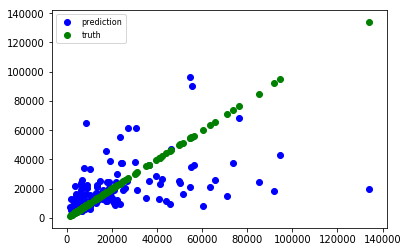

In [28]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=fcst_df[target_column_name],
    y_pred=fcst_df["predicted"],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET),
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

# Plot outputs
%matplotlib inline
test_pred = plt.scatter(fcst_df[target_column_name], fcst_df["predicted"], color="b")
test_test = plt.scatter(
    fcst_df[target_column_name], fcst_df[target_column_name], color="g"
)
plt.legend(
    (test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8
)
plt.show()

# Operationalize<a id="operationalize"></a>

_Operationalization_ means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.

In [ ]:
description = "AutoML OJ forecaster"
tags = None
model = remote_run.register_model(
    model_name=model_name, description=description, tags=tags
)

print(remote_run.model_id)

### Develop the scoring script

For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.

In [ ]:
script_file_name = "score_fcast.py"
best_run.download_file("outputs/scoring_file_v_1_0_0.py", script_file_name)

### Deploy the model as a Web Service on Azure Container Instance

In [ ]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(
    environment=best_run.get_environment(), entry_script=script_file_name
)

aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=2,
    memory_gb=4,
    tags={"type": "automl-forecasting"},
    description="Automl forecasting sample service",
)

aci_service_name = "automl-oj-forecast-01"
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

In [ ]:
aci_service.get_logs()

### Call the service

In [ ]:
import json

X_query = test.copy()
X_query.pop(target_column_name)
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
sample_quantiles = [0.025, 0.975]
test_sample = json.dumps(
    {"data": X_query.to_dict(orient="records"), "quantiles": sample_quantiles}
)
response = aci_service.run(input_data=test_sample)
# translate from networkese to datascientese
try:
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict["index"])
    y_fcst_all[time_column_name] = pd.to_datetime(
        y_fcst_all[time_column_name], unit="ms"
    )
    y_fcst_all["forecast"] = res_dict["forecast"]
    y_fcst_all["prediction_interval"] = res_dict["prediction_interval"]
except:
    print(res_dict)

In [ ]:
y_fcst_all.head()

### Delete the web service if desired

In [ ]:
serv = Webservice(ws, "automl-oj-forecast-01")
serv.delete()  # don't do it accidentally